In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
df = df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

In [4]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


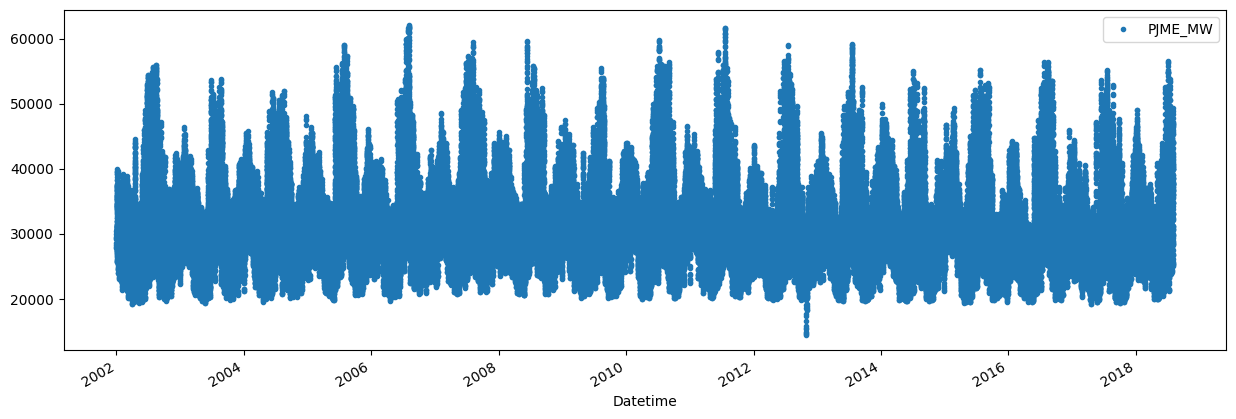

In [5]:
df.plot(style='.',figsize=(15,5))
plt.show()

Outliers

<Axes: ylabel='Frequency'>

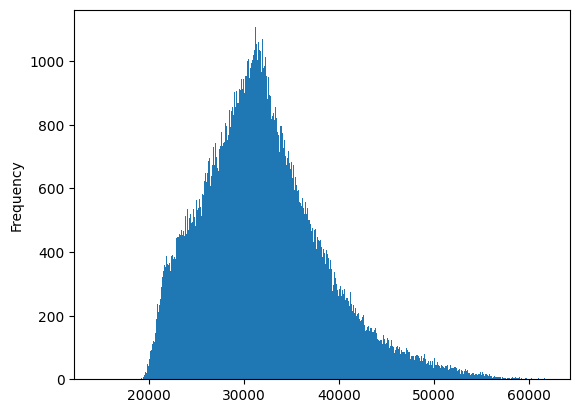

In [6]:
df['PJME_MW'].plot(kind='hist',bins=500)

<Axes: xlabel='Datetime'>

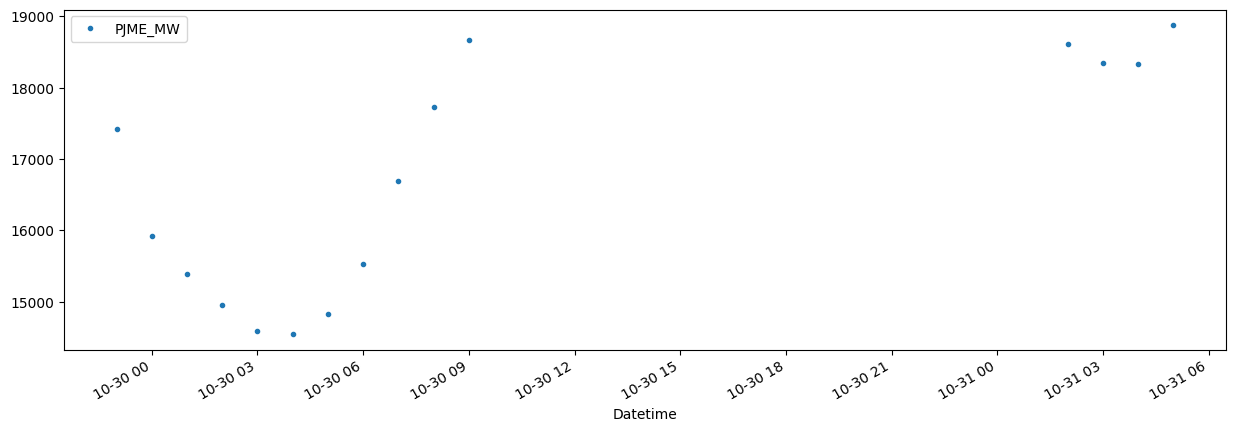

In [7]:
df.query('PJME_MW < 19_000').plot(figsize=(15,5),style='.')

In [8]:
df  = df.query('PJME_MW>19_000').copy()

Time series cross validation

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1, gap=24)
df = df.sort_index()

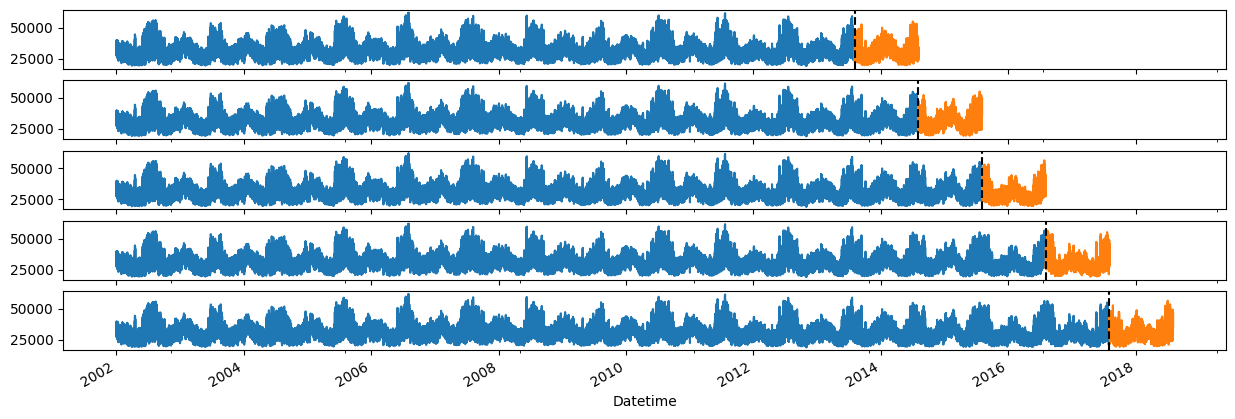

In [10]:
fig,axs = plt.subplots(5,1,figsize=(15,5),sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold])
    test['PJME_MW'].plot(ax=axs[fold])
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold = fold + 1

Feature Creation

In [11]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df ['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df 

In [12]:
df = create_features(df)

lag features

In [13]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [15]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


Train using cross validation

In [16]:
tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap=24)
df =df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000, early_stopping_rounds=50,objective='reg:linear',max_depth=3,learning_rate=0.01)
    reg.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


c:\Users\saza\.conda\envs\langchain\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:41:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


c:\Users\saza\.conda\envs\langchain\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:41:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.30469
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


c:\Users\saza\.conda\envs\langchain\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:41:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.65414
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


c:\Users\saza\.conda\envs\langchain\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:41:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.70000
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.29234
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.57123
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.47152
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.83008
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4053.00975
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


c:\Users\saza\.conda\envs\langchain\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:41:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [17]:
scores

[np.float64(3760.8277187583353),
 np.float64(3420.3046881354244),
 np.float64(3478.018038580526),
 np.float64(4053.009750964083),
 np.float64(4001.186553933809)]

In [18]:
df = create_features(df)

fold = 0
preds = []
scores = []

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 500, objective='reg:linear',max_depth=3,learning_rate=0.01)
reg.fit(X_all,y_all, eval_set=[(X_all,y_all)],verbose=100)

[0]	validation_0-rmse:32403.88991


c:\Users\saza\.conda\envs\langchain\lib\site-packages\xgboost\training.py:183: UserWarning: [13:41:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

save

In [19]:
reg.save_model('model.json')

In [24]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

prediction

In [ ]:
# Create a date range
future_dates = pd.date_range('2018-08-03 01:00:00', '2018-08-04 00:00:00', freq='1h')
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True

In [ ]:
df_and_future = pd.concat([df, future_df])

df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_with_features = df_and_future.query('isFuture == True').copy()

In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag1', 'lag2', 'lag3']

predictions = reg_new.predict(future_with_features[FEATURES])

future_with_features['prediction'] = predictions
print(future_with_features[['prediction']])

                       prediction
2018-08-03 01:00:00  28575.041016
2018-08-03 02:00:00  27978.013672
2018-08-03 03:00:00  27365.339844
2018-08-03 04:00:00  26971.216797
2018-08-03 05:00:00  27070.607422
2018-08-03 06:00:00  28074.919922
2018-08-03 07:00:00  29369.697266
2018-08-03 08:00:00  32282.082031
2018-08-03 09:00:00  34055.312500
2018-08-03 10:00:00  35640.230469
2018-08-03 11:00:00  38493.484375
2018-08-03 12:00:00  39992.824219
2018-08-03 13:00:00  41573.691406
2018-08-03 14:00:00  42482.523438
2018-08-03 15:00:00  43312.066406
2018-08-03 16:00:00  43500.941406
2018-08-03 17:00:00  44381.746094
2018-08-03 18:00:00  43857.722656
2018-08-03 19:00:00  42805.941406
2018-08-03 20:00:00  41199.761719
2018-08-03 21:00:00  40305.753906
2018-08-03 22:00:00  39476.960938
2018-08-03 23:00:00  36539.585938
2018-08-04 00:00:00  31660.847656
